# Display information about the NVIDIA GPU being used by this Google Colab notebook

In [ ]:
!nvidia-smi

Mon Apr 17 16:59:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import the os module to interact with the filesystem

# Download the ISIC 2020 dataset (JPEG images) and the corresponding ground truth labels
# These datasets are used for skin lesion classification tasks


In [ ]:
import os

# Download and extract the datasets, deleting after unzipped to create more storage space
!wget https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth.csv


--2023-04-17 16:59:38--  https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.49.44, 3.5.25.202, 3.5.29.160, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.49.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24707698022 (23G) [application/zip]
Saving to: ‘ISIC_2020_Training_JPEG.zip’

ISIC_2020_Training_ 100%[===================>]  23.01G  33.7MB/s    in 12m 57s 

2023-04-17 17:12:36 (30.3 MB/s) - ‘ISIC_2020_Training_JPEG.zip’ saved [24707698022/24707698022]

--2023-04-17 17:12:36--  https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth.csv
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.91.28, 52.217.170.33, 3.5.27.132, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)

# Unzip the content into a folder: /content/images


In [ ]:
!unzip -q ISIC_2020_Training_JPEG.zip -d /content
# Zip will unzip into a folder called 'train' we want this to be 'images'
!mv /content/train /content/images

# Import dependancies

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import DenseNet121, DenseNet201, InceptionV3, NASNetLarge, MobileNetV2
from google.colab import drive
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, matthews_corrcoef

# Read and process the ground truth CSV file
# Balance the dataset by selecting an equal number of benign and malignant images
# Split the balanced data into train and test sets (80% train, 20% test)
# Organize the train and test images into their respective benign and malignant folders


In [ ]:
# Read the ground truth CSV
df = pd.read_csv("ISIC_2020_Training_GroundTruth.csv")

# Count the number of benign and malignant images
benign_count = sum(df['benign_malignant'] == 'benign')
malignant_count = sum(df['benign_malignant'] == 'malignant')

print("Starting benign count:", benign_count)
print("Starting malignant count:", malignant_count)

# Determine the minimum count between the two classes
min_count = min(benign_count, malignant_count)

print("Minimum count to balance:", min_count);

# Balance the dataset by selecting an equal number of benign and malignant images
balanced_df = pd.concat([
    df[df['benign_malignant'] == 'benign'].sample(min_count, random_state=42),
    df[df['benign_malignant'] == 'malignant'].sample(min_count, random_state=42)
])

# Split the balanced data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

# Create folders for train and test images
for dataset in ['train', 'test']:
    for folder in ['benign', 'malignant']:
        path = f"/content/{dataset}/{folder}"
        if not os.path.exists(path):
            os.makedirs(path)

# Move train images to their respective folders
for index, row in train_df.iterrows():
    image_path = os.path.join("/content/images", row['image_name'] + ".jpg")
    if os.path.isfile(image_path):
        if row['benign_malignant'] == 'benign':
            shutil.copy(image_path, os.path.join("/content/train/benign", row['image_name'] + ".jpg"))
        else:
            shutil.copy(image_path, os.path.join("/content/train/malignant", row['image_name'] + ".jpg"))

# Move test images to their respective folders
for index, row in test_df.iterrows():
    image_path = os.path.join("/content/images", row['image_name'] + ".jpg")
    if os.path.isfile(image_path):
        if row['benign_malignant'] == 'benign':
            shutil.copy(image_path, os.path.join("/content/test/benign", row['image_name'] + ".jpg"))
        else:
            shutil.copy(image_path, os.path.join("/content/test/malignant", row['image_name'] + ".jpg"))


train_benign_count = len(os.listdir("/content/train/benign"))
train_malignant_count = len(os.listdir("/content/train/malignant"))
test_benign_count = len(os.listdir("/content/test/benign"))
test_malignant_count = len(os.listdir("/content/test/malignant"))

print()
print("Train:")
print(f"  Benign count: {train_benign_count}")
print(f"  Malignant count: {train_malignant_count}")

print("Test:")
print(f"  Benign count: {test_benign_count}")
print(f"  Malignant count: {test_malignant_count}")


Starting benign count: 32542
Starting malignant count: 584
Minimum count to balance: 584

Train:
  Benign count: 461
  Malignant count: 473
Test:
  Benign count: 123
  Malignant count: 111


# Split the train set into train and validation sets (80% train, 20% validation)
# Create data generators for training, validation, and test sets
# Configure the generators to resize the images, apply rescaling, and set batch size and class mode


In [ ]:
# Split the train set into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

print(train_df['benign_malignant'].value_counts())
IMG_SIZE = 224

# Create data generators for training, validation and test sets
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory="/content/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    directory="/content/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


test_generator = test_datagen.flow_from_directory(
    directory="/content/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Keep the order of the predictions for ensemble later
)

malignant    385
benign       362
Name: benign_malignant, dtype: int64
Found 748 images belonging to 2 classes.
Found 186 images belonging to 2 classes.
Found 234 images belonging to 2 classes.


# Mount Google Drive to save trained models so they can be used in multiple instances.

# Google Collab has a max of 12hrs

In [ ]:
drive.mount('/content/gdrive')

model_save_path = "/content/gdrive/MyDrive/saved_models"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Define the list of model architectures to train
# Train each model with their respective pre-trained weights and save the trained models

# I selected a smaller number of epochs for the sake of time and computational resources and acknowledge that training for more epochs could potentially lead to better performance

In [ ]:
# Define the list of models to train
model_architectures = [
    {"name": "DenseNet121", "model": DenseNet121},
    {"name": "DenseNet201", "model": DenseNet201},
    {"name": "InceptionV3", "model": InceptionV3},
    {"name": "NASNetLarge", "model": NASNetLarge},
    {"name": "MobileNetV2", "model": MobileNetV2}, ]

# Iterate through each model architecture
for arch in model_architectures:
    print(f"Training {arch['name']} model...")

    # Initialize the base model with pre-trained weights
    base_model = arch['model'](
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Set the base model as non-trainable (use pre-trained weights)
    base_model.trainable = False

    # Define the input layer
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Pass the inputs through the base model
    x = base_model(inputs, training=False)

    # Add a global average pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Add the output layer with sigmoid activation for binary classification
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Build the final model
    model = tf.keras.Model(inputs, outputs)

    # Compile the model with Adam optimizer and binary cross-entropy loss
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    # Train the model using the training and validation data
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator),
        verbose=1
    )

    # Save the trained model to Google Drive
    model_save_path = "/content/gdrive/MyDrive/saved_models"
    model.save(os.path.join(model_save_path, f"{arch['name']}.h5"))

    print(f"{arch['name']} model saved.")


Training MobileNetV2 model...
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
24/24 [==============================] - 148s 6s/step - loss: 0.6613 - accuracy: 0.6364 - val_loss: 0.5587 - val_accuracy: 0.7097
Epoch 2/10
24/24 [==============================] - 147s 6s/step - loss: 0.5093 - accuracy: 0.7620 - val_loss: 0.5211 - val_accuracy: 0.7097
Epoch 3/10
24/24 [==============================] - 130s 5s/step - loss: 0.4650 - accuracy: 0.7807 - val_loss: 0.5082 - val_accuracy: 0.7043
Epoch 4/10
24/24 [==============================] - 148s 6s/step - loss: 0.4408 - accuracy: 0.7914 - val_loss: 0.5031 - val_accuracy: 0.7312
Epoch 5/10
24/24 [==============================] - 136s 6s/step - loss: 0.4300 - accuracy: 0.7914 - val_loss: 0.5021 - val_accuracy: 0.7366
Epoch 6/10
24/24 [==============================] - 128s 5s/step - loss: 0.4135 - accuracy: 0.8128 - val_loss: 0.4963 - val_accuracy: 0.7366
Epoch 7/10
24/24 [==============================] - 129s 5s/s

# Prepare the test images and labels by loading and preprocessing them
# Read test images from the test directory, resize, and rescale them
# Store the preprocessed images and their corresponding labels in lists


In [ ]:
# Prepare the test images and labels
test_images = []
test_labels = []
test_folder = "/content/test"

# Iterate over each class folder in the test directory
for label, folder in enumerate(['benign', 'malignant']):
    folder_path = os.path.join(test_folder, folder)

    # Iterate over each image in the class folder
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        img = cv2.imread(image_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0

            # Append the preprocessed image and its label to the test images and labels list
            test_images.append(img)
            test_labels.append(label)

# Convert the test images list to a numpy array
test_images = np.array(test_images)

# Evaluate the performance of each trained model on the test dataset
# Load each saved model, generate predictions, and calculate evaluation metrics


In [ ]:
# Load and test each model
model_predictions = []
for arch in model_architectures:
    print(f"Evaluating {arch['name']} model...")

    # Load the saved model from Google Drive
    model_path = os.path.join(model_save_path, f"{arch['name']}.h5")
    model = load_model(model_path)

    # Generate predictions for the test images using the loaded model
    predictions = model.predict(test_images)
    predictions = [1 if p >= 0.5 else 0 for p in predictions]

    # Append the model's predictions to the model_predictions list
    model_predictions.append(predictions)

    # Calculate evaluation metrics (accuracy, precision, recall, f1-score) for the model's predictions
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions)
    recall = recall_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)

    # Print the model's evaluation metrics
    print(f"{arch['name']} model evaluation:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}\n")

Evaluating DenseNet121 model...
8/8 [==============================] - 12s 130ms/step
DenseNet121 model evaluation:
  Accuracy: 0.6623931623931624
  Precision: 0.625
  Recall: 0.7207207207207207
  F1-score: 0.6694560669456067

Evaluating DenseNet201 model...
8/8 [==============================] - 5s 136ms/step
DenseNet201 model evaluation:
  Accuracy: 0.6538461538461539
  Precision: 0.5862068965517241
  Recall: 0.918918918918919
  F1-score: 0.7157894736842105

Evaluating InceptionV3 model...
8/8 [==============================] - 4s 108ms/step
InceptionV3 model evaluation:
  Accuracy: 0.688034188034188
  Precision: 0.6319444444444444
  Recall: 0.8198198198198198
  F1-score: 0.7137254901960783

Evaluating NASNetLarge model...
8/8 [==============================] - 9s 156ms/step
NASNetLarge model evaluation:
  Accuracy: 0.6709401709401709
  Precision: 0.6075949367088608
  Recall: 0.8648648648648649
  F1-score: 0.7137546468401488

Evaluating MobileNetV2 model...
8/8 [=====================

# Find the best weights for an ensemble of models
# Generate all possible weight combinations and evaluate their performance on the test dataset
# Store the best weight combination and its corresponding accuracy


In [ ]:
# Define the list of possible weights
weight_values = [0.1, 0.2, 0.3, 0.4]

# Generate all possible combinations of weights
weight_combinations = list(itertools.product(weight_values, repeat=len(model_architectures)))

best_weights = None
best_accuracy = 0

# Loop through all weight combinations
for weights in weight_combinations:
    # Check if the sum of the weights is 1.0 (if not, skip this combination)
    if round(sum(weights), 2) != 1.0:
        continue

    # Calculate the weighted predictions
    combined_predictions = np.sum(
        [np.array(predictions) * weight for predictions, weight in zip(model_predictions, weights)],
        axis=0
    )

    # Convert the predictions to binary labels
    threshold = 0.5
    binary_predictions = (combined_predictions > threshold).astype(int)

    # Calculate the accuracy
    accuracy = accuracy_score(test_labels, binary_predictions)

    # Check if the accuracy is better than the best accuracy found so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = weights

print(f"Best weights: {best_weights}")
print(f"Best accuracy: {best_accuracy}")


Best weights: (0.1, 0.1, 0.1, 0.4, 0.3)
Best accuracy: 0.6965811965811965


# Summary of the Ensemble performance

In [ ]:
# Calculate the weighted predictions using the best weights
combined_predictions = np.sum(
    [np.array(predictions) * weight for predictions, weight in zip(model_predictions, best_weights)],
    axis=0
)

# Convert the predictions to binary labels
threshold = 0.5
binary_predictions = (combined_predictions > threshold).astype(int)

# Calculate the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(test_labels, binary_predictions)
precision = precision_score(test_labels, binary_predictions)
recall = recall_score(test_labels, binary_predictions)
f1 = f1_score(test_labels, binary_predictions)

print("Ensemble model evaluation:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Ensemble model evaluation:
Accuracy: 0.6965811965811965
Precision: 0.6351351351351351
Recall: 0.8468468468468469
F1-score: 0.7258687258687259


# The performance of the models seems to be moderate, with accuracy ranging from 65% to 69%.

These accuracy levels may be acceptable for some use cases but for this project (critical medical diagnoses) a higher performance would be desirable.

# Adding fine tuning and to try to improve the accuracy

In [ ]:
# Iterate through each model architecture
for arch in model_architectures:
    print(f"Training {arch['name']} model...")

    # Initialize the base model with pre-trained weights
    base_model = arch['model'](
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Set the base model as non-trainable (use pre-trained weights)
    base_model.trainable = False

    # Define the input layer
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Pass the inputs through the base model
    x = base_model(inputs, training=False)

    # Add a global average pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Add the output layer with sigmoid activation for binary classification
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Build the final model
    model = tf.keras.Model(inputs, outputs)

    # Compile the model with Adam optimizer and binary cross-entropy loss
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    # Train the model using the training and validation data
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator),
        verbose=1
    )

    # Unfreeze the last few layers of the base model for fine-tuning
    for layer in base_model.layers[-5:]:
        layer.trainable = True

    # Compile the model with a lower learning rate for fine-tuning
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    # Fine-tune the model using the training and validation data
    fine_tuning_history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator),
        verbose=1
    )

    # Save the trained model to Google Drive
    model_save_path = "/content/gdrive/MyDrive/saved_models"
    model.save(os.path.join(model_save_path, f"{arch['name']}_finetuned.h5"))

    print(f"{arch['name']} model saved.")


Training DenseNet121 model...
Epoch 1/10
24/24 [==============================] - 173s 7s/step - loss: 0.6299 - accuracy: 0.6578 - val_loss: 0.6206 - val_accuracy: 0.7097
Epoch 2/10
24/24 [==============================] - 142s 6s/step - loss: 0.5466 - accuracy: 0.7286 - val_loss: 0.6045 - val_accuracy: 0.7527
Epoch 3/10
24/24 [==============================] - 140s 6s/step - loss: 0.5198 - accuracy: 0.7460 - val_loss: 0.5787 - val_accuracy: 0.7151
Epoch 4/10
24/24 [==============================] - 142s 6s/step - loss: 0.4885 - accuracy: 0.7647 - val_loss: 0.5681 - val_accuracy: 0.7097
Epoch 5/10
24/24 [==============================] - 139s 6s/step - loss: 0.4679 - accuracy: 0.7821 - val_loss: 0.5640 - val_accuracy: 0.7258
Epoch 6/10
24/24 [==============================] - 137s 6s/step - loss: 0.4606 - accuracy: 0.7861 - val_loss: 0.5599 - val_accuracy: 0.7366
Epoch 7/10
24/24 [==============================] - 143s 6s/step - loss: 0.4433 - accuracy: 0.7848 - val_loss: 0.5578 - val_

Epoch 1/5
24/24 [==============================] - 157s 6s/step - loss: 0.4185 - accuracy: 0.7995 - val_loss: 0.5405 - val_accuracy: 0.7473
Epoch 2/5
24/24 [==============================] - 141s 6s/step - loss: 0.4115 - accuracy: 0.8048 - val_loss: 0.5386 - val_accuracy: 0.7473
Epoch 3/5
24/24 [==============================] - 145s 6s/step - loss: 0.4028 - accuracy: 0.8249 - val_loss: 0.5388 - val_accuracy: 0.7419
Epoch 4/5
24/24 [==============================] - 141s 6s/step - loss: 0.4003 - accuracy: 0.8222 - val_loss: 0.5386 - val_accuracy: 0.7366
Epoch 5/5
24/24 [==============================] - 144s 6s/step - loss: 0.3915 - accuracy: 0.8302 - val_loss: 0.5279 - val_accuracy: 0.7473
DenseNet121 model saved.
Training DenseNet201 model...
74836368/74836368 [==============================] - 3s 0us/step
Epoch 1/10
24/24 [==============================] - 181s 7s/step - loss: 0.6273 - accuracy: 0.6444 - val_loss: 0.5848 - val_accuracy: 0.6989
Epoch 2/10
24/24 [=====================

Epoch 1/5
24/24 [==============================] - 175s 7s/step - loss: 0.3751 - accuracy: 0.8289 - val_loss: 0.4645 - val_accuracy: 0.8172
Epoch 2/5
24/24 [==============================] - 140s 6s/step - loss: 0.3650 - accuracy: 0.8516 - val_loss: 0.4616 - val_accuracy: 0.7957
Epoch 3/5
24/24 [==============================] - 148s 6s/step - loss: 0.3598 - accuracy: 0.8382 - val_loss: 0.4554 - val_accuracy: 0.8118
Epoch 4/5
24/24 [==============================] - 143s 6s/step - loss: 0.3533 - accuracy: 0.8356 - val_loss: 0.4577 - val_accuracy: 0.8172
Epoch 5/5
24/24 [==============================] - 141s 6s/step - loss: 0.3558 - accuracy: 0.8556 - val_loss: 0.4516 - val_accuracy: 0.7796
DenseNet201 model saved.
Training InceptionV3 model...
87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/10
24/24 [==============================] - 153s 6s/step - loss: 0.6589 - accuracy: 0.6083 - val_loss: 0.6021 - val_accuracy: 0.6828
Epoch 2/10
24/24 [=====================

Epoch 1/5
24/24 [==============================] - 155s 6s/step - loss: 0.3886 - accuracy: 0.8302 - val_loss: 0.5377 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 147s 6s/step - loss: 0.3683 - accuracy: 0.8516 - val_loss: 0.5447 - val_accuracy: 0.7312
Epoch 3/5
24/24 [==============================] - 143s 6s/step - loss: 0.3535 - accuracy: 0.8409 - val_loss: 0.5462 - val_accuracy: 0.7366
Epoch 4/5
24/24 [==============================] - 148s 6s/step - loss: 0.3429 - accuracy: 0.8596 - val_loss: 0.5581 - val_accuracy: 0.7204
Epoch 5/5
24/24 [==============================] - 140s 6s/step - loss: 0.3322 - accuracy: 0.8690 - val_loss: 0.5586 - val_accuracy: 0.7204
InceptionV3 model saved.
Training NASNetLarge model...
343610240/343610240 [==============================] - 11s 0us/step
Epoch 1/10
24/24 [==============================] - 174s 6s/step - loss: 0.6187 - accuracy: 0.6564 - val_loss: 0.6188 - val_accuracy: 0.6720
Epoch 2/10
24/24 [==================

Epoch 1/5
24/24 [==============================] - 173s 6s/step - loss: 0.3594 - accuracy: 0.8476 - val_loss: 0.5973 - val_accuracy: 0.7312
Epoch 2/5
24/24 [==============================] - 142s 6s/step - loss: 0.3388 - accuracy: 0.8636 - val_loss: 0.5873 - val_accuracy: 0.6989
Epoch 3/5
24/24 [==============================] - 140s 6s/step - loss: 0.3332 - accuracy: 0.8730 - val_loss: 0.5834 - val_accuracy: 0.6720
Epoch 4/5
24/24 [==============================] - 144s 6s/step - loss: 0.3216 - accuracy: 0.8730 - val_loss: 0.5868 - val_accuracy: 0.6935
Epoch 5/5
24/24 [==============================] - 140s 6s/step - loss: 0.3167 - accuracy: 0.8703 - val_loss: 0.5977 - val_accuracy: 0.7258
NASNetLarge model saved.
Training MobileNetV2 model...
9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/10
24/24 [==============================] - 146s 6s/step - loss: 0.6431 - accuracy: 0.6217 - val_loss: 0.5707 - val_accuracy: 0.6828
Epoch 2/10
24/24 [=======================

Epoch 1/5
24/24 [==============================] - 148s 6s/step - loss: 0.3930 - accuracy: 0.8262 - val_loss: 0.5387 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 152s 6s/step - loss: 0.3806 - accuracy: 0.8329 - val_loss: 0.5167 - val_accuracy: 0.7419
Epoch 3/5
24/24 [==============================] - 136s 6s/step - loss: 0.3729 - accuracy: 0.8382 - val_loss: 0.4888 - val_accuracy: 0.7849
Epoch 4/5
24/24 [==============================] - 136s 6s/step - loss: 0.3655 - accuracy: 0.8369 - val_loss: 0.5008 - val_accuracy: 0.7581
Epoch 5/5
24/24 [==============================] - 148s 6s/step - loss: 0.3557 - accuracy: 0.8463 - val_loss: 0.4915 - val_accuracy: 0.7688
MobileNetV2 model saved.


Evaluating DenseNet121 finetuned model...


8/8 [==============================] - 5s 39ms/step
DenseNet121 model evaluation:
  Accuracy: 0.6623931623931624
  Precision: 0.6012658227848101
  Recall: 0.8558558558558559
  F1-score: 0.7063197026022304
  Confusion matrix: 
[[60 63]
 [16 95]]
  AUC-ROC: 0.7453306965502088
  MCC: 0.36644484679082756



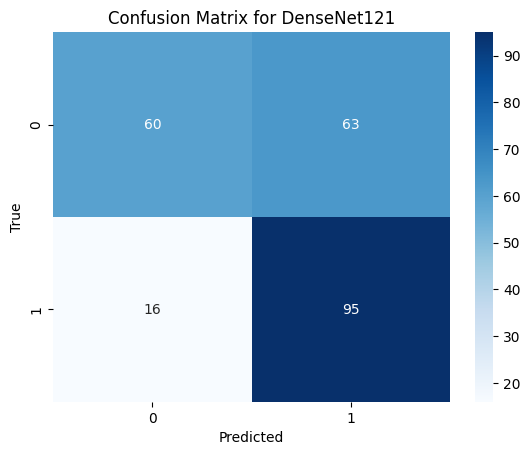

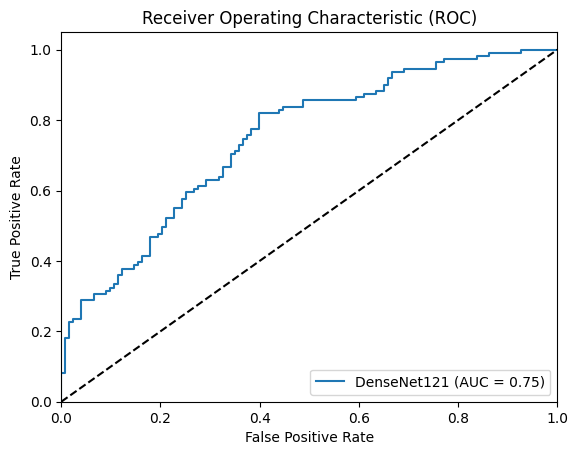

Evaluating DenseNet201 finetuned model...


8/8 [==============================] - 5s 57ms/step
DenseNet201 model evaluation:
  Accuracy: 0.6239316239316239
  Precision: 0.56353591160221
  Recall: 0.918918918918919
  F1-score: 0.6986301369863014
  Confusion matrix: 
[[ 44  79]
 [  9 102]]
  AUC-ROC: 0.7639346663736908
  MCC: 0.33003174636621696



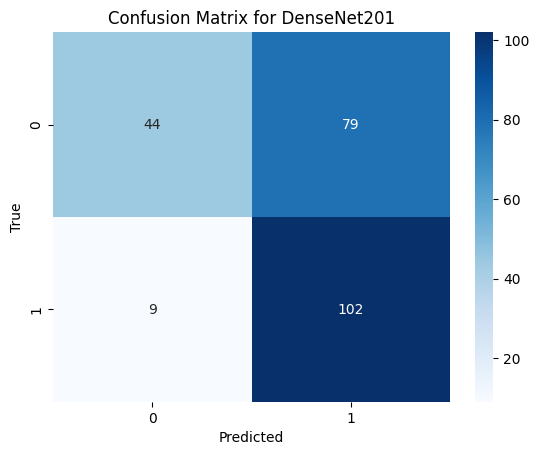

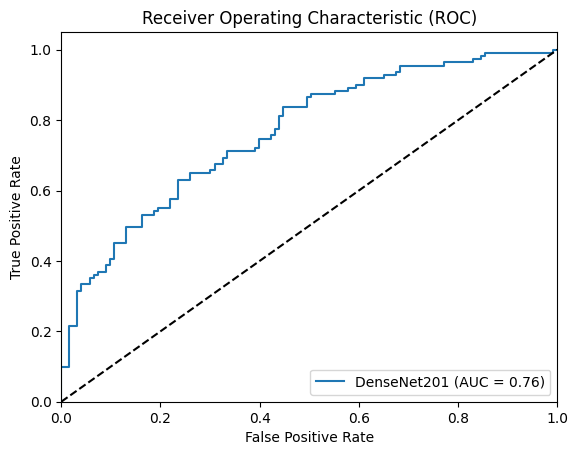

Evaluating InceptionV3 finetuned model...
8/8 [==============================] - 2s 31ms/step
InceptionV3 model evaluation:
  Accuracy: 0.688034188034188
  Precision: 0.6759259259259259
  Recall: 0.6576576576576577
  F1-score: 0.6666666666666667
  Confusion matrix: 
[[88 35]
 [38 73]]
  AUC-ROC: 0.7499450670182377
  MCC: 0.37372120906708856



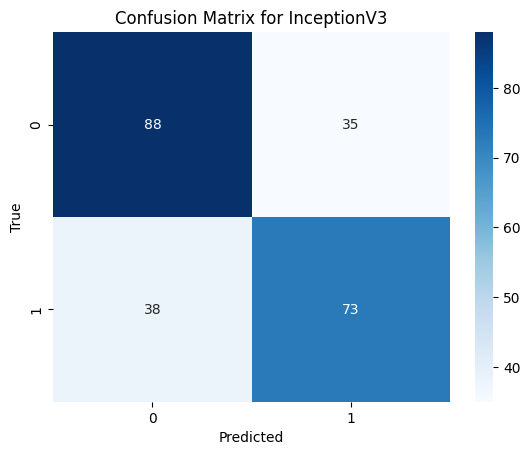

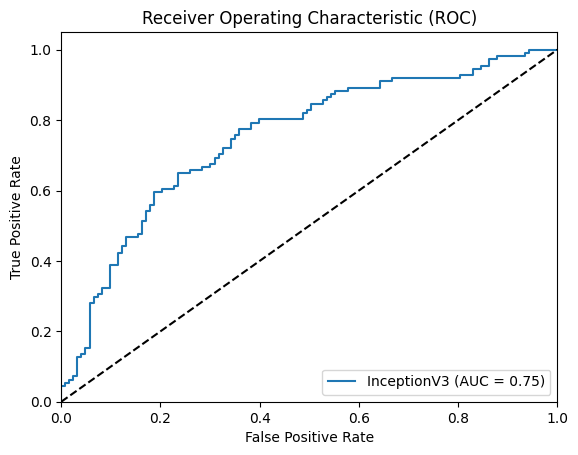

Evaluating NASNetLarge finetuned model...
8/8 [==============================] - 8s 119ms/step
NASNetLarge model evaluation:
  Accuracy: 0.6239316239316239
  Precision: 0.5688622754491018
  Recall: 0.8558558558558559
  F1-score: 0.683453237410072
  Confusion matrix: 
[[51 72]
 [16 95]]
  AUC-ROC: 0.7489928953343588
  MCC: 0.29879245429862344



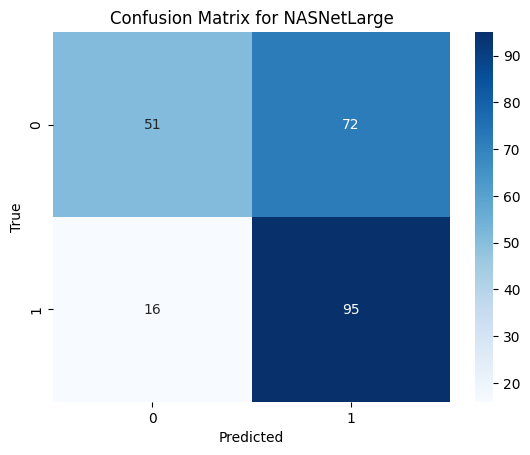

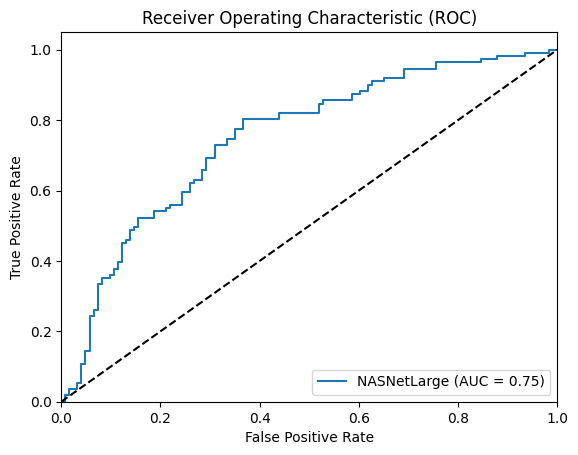

Evaluating MobileNetV2 finetuned model...


8/8 [==============================] - 1s 21ms/step
MobileNetV2 model evaluation:
  Accuracy: 0.6410256410256411
  Precision: 0.5859872611464968
  Recall: 0.8288288288288288
  F1-score: 0.6865671641791046
  Confusion matrix: 
[[58 65]
 [19 92]]
  AUC-ROC: 0.7635684464952758
  MCC: 0.31921297473985993



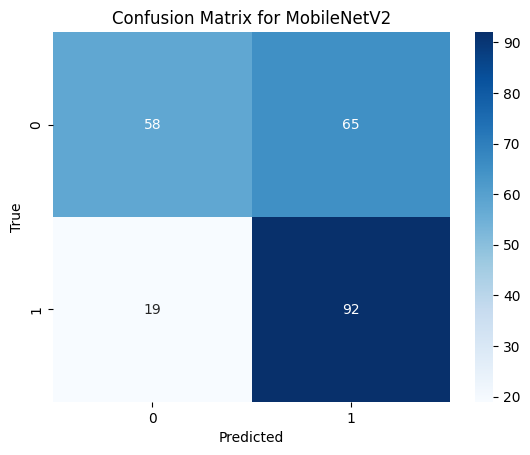

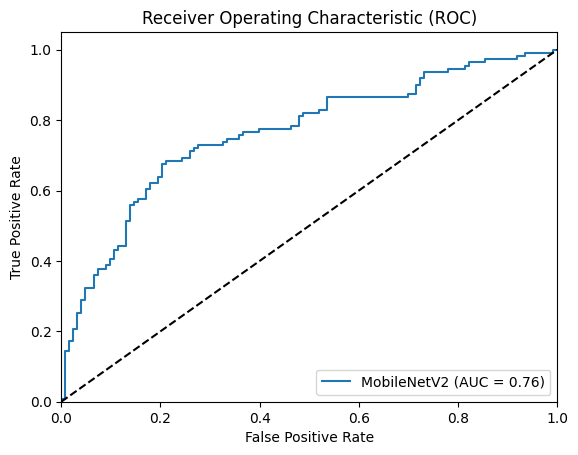

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')

# Initialize an empty dictionary to store MCC scores
mcc_scores = {}

# Load and test each model
model_predictions = []
for arch in model_architectures:
    print(f"Evaluating {arch['name']} finetuned model...")

    # Load the saved model from Google Drive
    model_path = os.path.join(model_save_path, f"{arch['name']}_finetuned.h5")
    model = load_model(model_path)

    # Generate predictions for the test images using the loaded model
    predictions = model.predict(test_images)
    predictions_binary = [1 if p >= 0.5 else 0 for p in predictions]

    # Append the model's predictions to the model_predictions list
    model_predictions.append(predictions_binary)

    # Calculate evaluation metrics (accuracy, precision, recall, f1-score, confusion matrix, AUC-ROC, and MCC) for the model's predictions
    accuracy = accuracy_score(test_labels, predictions_binary)
    precision = precision_score(test_labels, predictions_binary)
    recall = recall_score(test_labels, predictions_binary)
    f1 = f1_score(test_labels, predictions_binary)
    cm = confusion_matrix(test_labels, predictions_binary)
    auc_roc = roc_auc_score(test_labels, predictions)
    mcc = matthews_corrcoef(test_labels, predictions_binary)

    # Print the model's evaluation metrics
    print(f"{arch['name']} model evaluation:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Confusion matrix: \n{cm}")
    print(f"  AUC-ROC: {auc_roc}")
    print(f"  MCC: {mcc}\n")

    # Store the MCC score in the dictionary
    mcc_scores[arch['name']] = mcc

    # Plot the confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, arch['name'])
    plt.show()

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(test_labels, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plot_roc_curve(fpr, tpr, roc_auc, arch['name'])
    plt.show()


In [ ]:
# Define the list of possible weights
weight_values = [0.1, 0.2, 0.3, 0.4]

# Generate all possible combinations of weights
weight_combinations = list(itertools.product(weight_values, repeat=len(model_architectures)))

best_weights = None
best_accuracy = 0

# Loop through all weight combinations
for weights in weight_combinations:
    # Check if the sum of the weights is 1.0 (if not, skip this combination)
    if round(sum(weights), 2) != 1.0:
        continue

    # Calculate the weighted predictions
    combined_predictions = np.sum(
        [np.array(predictions) * weight for predictions, weight in zip(model_predictions, weights)],
        axis=0
    )

    # Convert the predictions to binary labels
    threshold = 0.5
    binary_predictions = (combined_predictions > threshold).astype(int)

    # Calculate the accuracy
    accuracy = accuracy_score(test_labels, binary_predictions)

    # Check if the accuracy is better than the best accuracy found so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = weights

print(f"Best weights: {best_weights}")
print(f"Best accuracy: {best_accuracy}")


Best weights: (0.1, 0.1, 0.3, 0.1, 0.4)
Best accuracy: 0.688034188034188


Ensemble model evaluation:
Accuracy: 0.688034188034188
Precision: 0.6266666666666667
Recall: 0.8468468468468469
F1-score: 0.7203065134099618
  Confusion matrix: 
[[67 56]
 [17 94]]
  AUC-ROC: 0.6957811470006592
  MCC: 0.4075957404067199



Text(0, 0.5, 'Model')

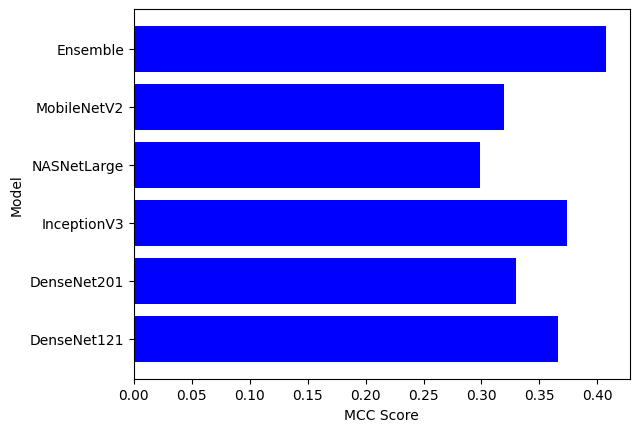

In [ ]:
# Calculate the weighted predictions using the best weights
combined_predictions = np.sum(
    [np.array(predictions) * weight for predictions, weight in zip(model_predictions, best_weights)],
    axis=0
)

# Convert the predictions to binary labels
threshold = 0.5
binary_predictions = (combined_predictions > threshold).astype(int)

# Calculate the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(test_labels, binary_predictions)
precision = precision_score(test_labels, binary_predictions)
recall = recall_score(test_labels, binary_predictions)
f1 = f1_score(test_labels, binary_predictions)
cm = confusion_matrix(test_labels, binary_predictions)
auc_roc = roc_auc_score(test_labels, binary_predictions)
mcc = matthews_corrcoef(test_labels, binary_predictions)

print("Ensemble model evaluation:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"  Confusion matrix: \n{cm}")
print(f"  AUC-ROC: {auc_roc}")
print(f"  MCC: {mcc}\n")

mcc_scores['Ensemble'] = mcc

plt.figure()
plt.barh(list(mcc_scores.keys()), list(mcc_scores.values()), color='blue')
plt.xlabel('MCC Score')
plt.ylabel('Model')
